# Stabilized ICA for EEG/MEG data   

In this jupyter notebook we propose a brief example for the use of our stabilized ICA algorithm on EEG/MEG data. We study the detection of artifacts (ex: ocular and heartbeat artifacts) and biological signals for multi-channels Magnetoencephalography data.

**Note :** this jupyter notebook is based on the tutorials of the [MNE python package](https://mne.tools/stable/index.html). We borrowed several functions from this package to pre-process the data and plot the results of stabilized ICA. **To run this example you need first to [install the MNE python package](https://mne.tools/stable/install/index.html).**

In [1]:
from time import time

import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


## 0. Load data   

The data set we are working with is extracted from the [MNE python package](https://mne.tools/stable/index.html). You can find a brief description of it [here](https://mne.tools/stable/overview/datasets_index.html#sample). It contains EEG and MEG data acquired simultaneously on a single subject. 

In [2]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file C:\Users\ncaptier\mne_data\MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


As a first pre-processing step, we remove the low-frequency drifts which can affect the quality of ICA results. For more information, see the tutorials [Filtering and resampling data](https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#slow-drifts) and [Repairing artifacts with ICA](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#filtering-to-remove-slow-drifts) of the MNE package.

In [3]:
raw = raw.filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 sec)



For this experiment we will only focus on the MEG channels. We will extract these channels via the picks object. We will also reject signal periods based on peak-to-peak amplitude for MEG data (by default we will deal with signal periods of 2.0 seconds). You can find more details [here](https://mne.tools/stable/auto_tutorials/preprocessing/20_rejecting_bad_data.html#rejecting-epochs-based-on-channel-amplitude).

In [4]:
picks = mne.pick_types(raw.info, meg=True)
reject = dict(mag=5e-12, grad=4000e-13)

Using matplotlib as 2D backend.


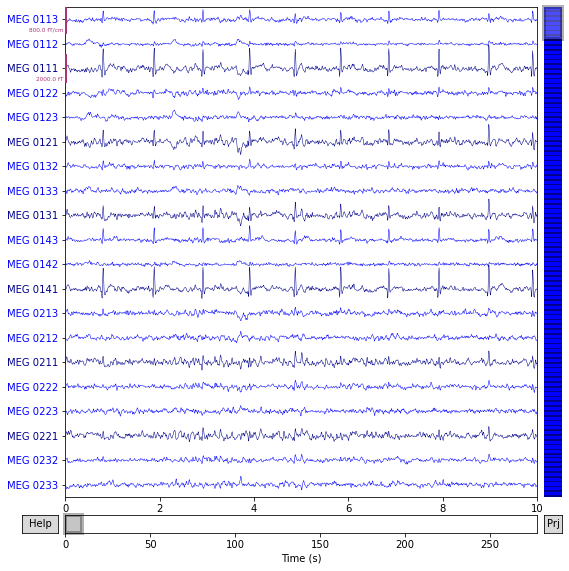

In [5]:
fig = raw.plot(order = picks)

## 1. Perform ICA with MNE 

We first perform ICA decomposition without stabilization with the tools provided by the [MNE python package](https://mne.tools/stable/index.html). We simply followed the tutorial [Repairing artifacts with ICA](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html) and the example [Comparing the different ICA algorithms in MNE](https://mne.tools/stable/auto_examples/preprocessing/ica_comparison.html). **We will extract 30 components.**

In [6]:
ica = ICA(n_components=30 , random_state = 0)
ica.fit(raw, picks=picks, reject=reject)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [12642, 12943]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [17458, 17759]
Selecting by number: 30 components
Fitting ICA took 4.2s.


Method,fastica
Fit,82 iterations on raw data (40936 samples)
ICA components,30
Explained variance,82.1 %
Available PCA components,305
Channel types,"mag, grad"
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=31, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


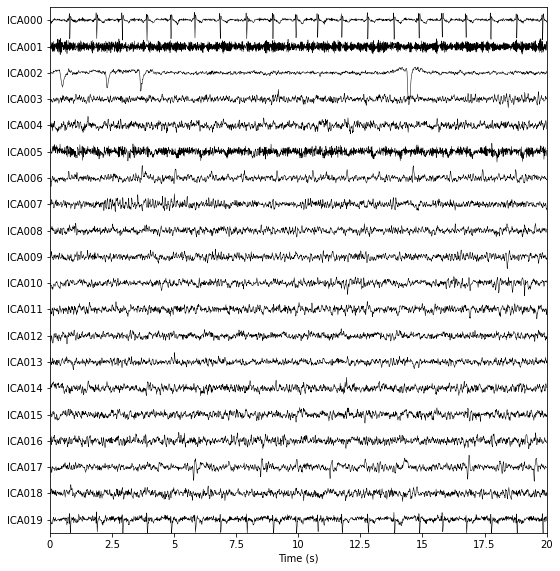

In [7]:
fig = ica.plot_sources(raw , show_scrollbars=False , title = "10 ICA sources")

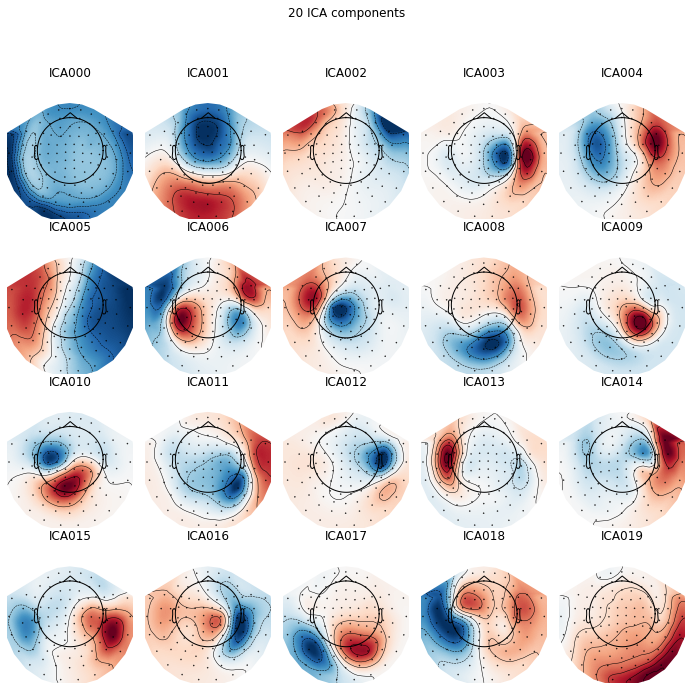

In [8]:
plot_components = ica.plot_components(picks = range(20) , title = '20 ICA components')

## 2. Perform ICA with stabilized-ICA

We will now perform ICA decomposition with our stabilized ICA algorithm. We will extract **30 components** and use **100 runs** to stabilize the results.   

Compared to ICA performed with MNE, we expect stabilized ICA to provide a ranking of the extracted ICA components with respect to their reliability/stability. This ranking should draw the user attention on the top first stabilized components and help him for the detection of potential artifacts and biological phenomena.

In [9]:
from sica.base import StabilizedICA

# MNE functions for preprocessing the MEG data like mne.preprocessing.ICA
from mne.utils.numerics import _reject_data_segments
from mne.io.pick import pick_info , _picks_to_idx
from mne.preprocessing.ica import _check_start_stop

### 2.1 Pre-processing

In order to deal with the MEG data in a proper way and perform the same operations as the ones `mne.preprocessing.ICA` does internally we will need to use a few functions of the MNE python package.

First, we only select the MEG data (using the `picks` object) and all the available time points (using `start` and `stop`). We also ensure that data segments pre-annotated with description starting with 'bad' are omitted. Then, we reject data segments of 2.0 seconds based on peak-to-peak amplitude (using the `reject` object).

In [10]:
# Selecting MEG channels, time samples and rejecting 'bad' annotated segments
picks = _picks_to_idx(raw.info, picks, allow_empty=False, with_ref_meg=False)
start, stop = _check_start_stop(raw, start = None , stop = None)
data = raw.get_data(picks, start = start, stop = stop, reject_by_annotation = 'omit')

# Rejecting segments based on peak-to-peak amplitude
info = pick_info(raw.info, picks)
data, drop_inds_ = _reject_data_segments(data, reject = reject , flat = None , decim = None , info = info , tstep = 2.0)

    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [12642, 12943]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [17458, 17759]


### 2.2 Stabilized ICA decomposition

**Note :** here we use the default settings of `sica.base.StabilizedICA` fit method but you can also play with the different parameters and compare the results (see the [documentation](https://stabilized-ica.readthedocs.io/en/latest/modules/generated/sica.base.StabilizedICA.html#sica.base.StabilizedICA) for more details). In particular, using the `algorithm` parameter, you can have access to different ICA solvers (the same as those implemented in MNE) and perform analyses similar to the one developed in the example [Comparing the different ICA algorithms in MNE](https://mne.tools/stable/auto_examples/preprocessing/ica_comparison.html).

running time (min): 01:53.81


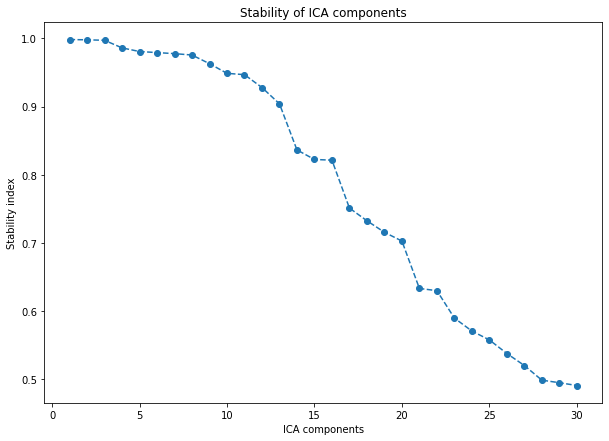

In [11]:
start = time()

sICA = StabilizedICA(n_components = 30 , max_iter = 2000 , n_jobs = -1)
sICA.fit(data.T , n_runs = 100 , plot = True , normalize = True , reorientation = False)

end = time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

running time (min): 02:51.84


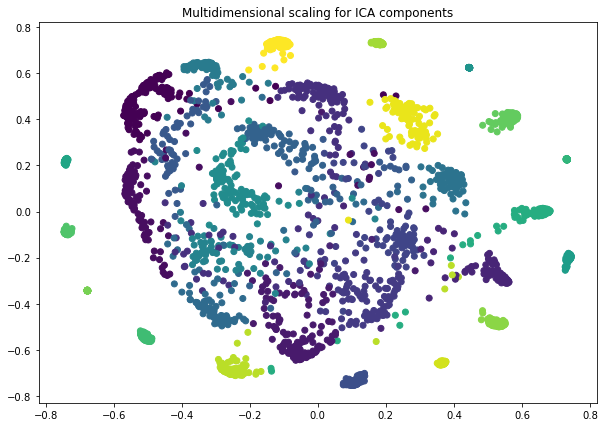

In [12]:
fig , ax = plt.subplots(figsize = (10 , 7))

start = time()

sICA.projection(ax = ax , method = 'mds')
ax.set_title("Multidimensional scaling for ICA components")

end = time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

### 2.3 Plotting stabilized ICA sources and components

Text(0.5, 0.98, 'Top 10 ICA sources')

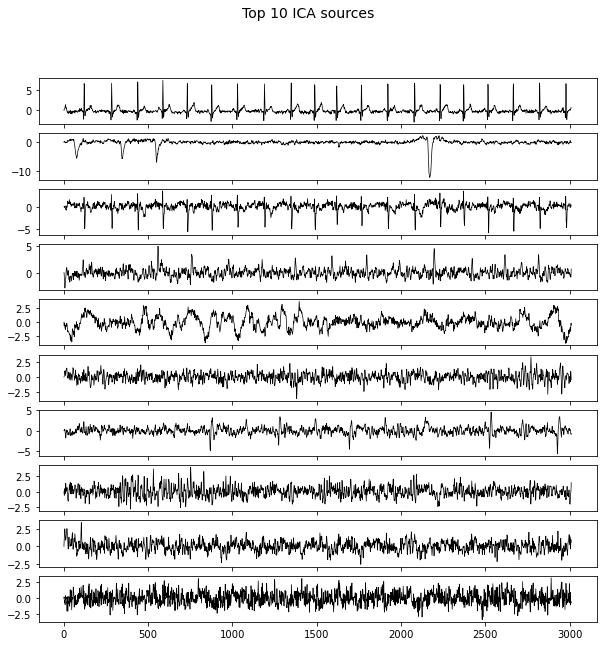

In [13]:
fig , axes = plt.subplots(10 , 1 , figsize = (10 , 10) , sharex = True)
axes = axes.flatten()

for i in range(10):
    axes[i].plot(sICA.S_[i, :3011] , c = 'k' , linewidth=0.7)
    
fig.suptitle("Top 10 ICA sources" , fontsize = 14)

**Note :** In the following, for plotting the ICA components the same way that MNE does we need to use several functions of this package.

In [14]:
from mne.viz.utils import _prepare_trellis , _setup_vmin_vmax , tight_layout , plt_show , _setup_cmap
from mne.viz.topomap import _prepare_topomap_plot , _hide_frame , plot_topomap

Text(0.5, 0.98, 'Top 20 ICA components')

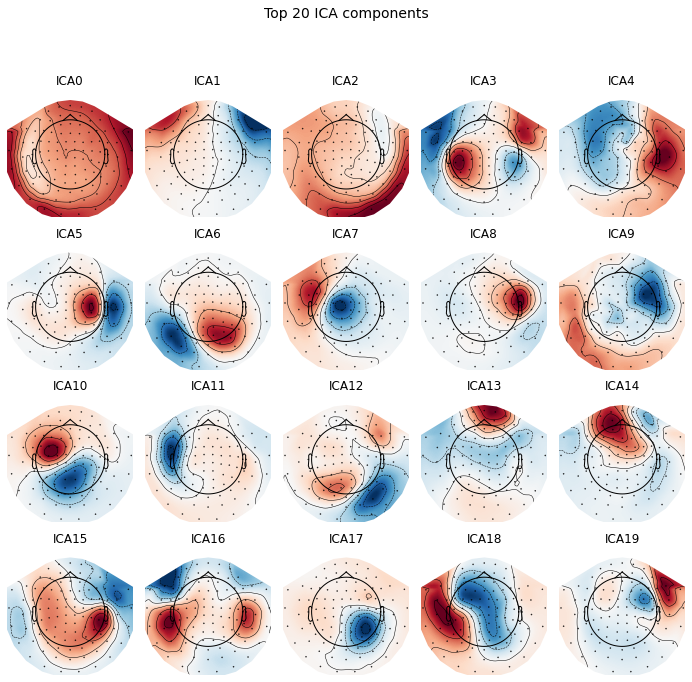

In [15]:
# 1. Get ICA components 
data_picks, pos, _ , _ , _ , _ , _  = _prepare_topomap_plot(ica, ch_type = 'mag', sphere=None)
comps = sICA.A_.T[: , data_picks]

# 2. Prepare figure and color map
fig, axes, _, _ = _prepare_trellis(20, ncols=5)
cmap = _setup_cmap('RdBu_r', n_axes=20)

# 3. Plot ICA components
for i in range(20) :
    vmin_, vmax_ = _setup_vmin_vmax(comps[i , :] , None, None)
    im = plot_topomap(comps[i, :].flatten(), pos, show = False ,vmin=vmin_, vmax=vmax_, axes=axes[i], cmap=cmap[0], ch_type='mag')[0]
    axes[i].set_title("ICA" + str(i))
    _hide_frame(axes[i])
    
tight_layout(fig=fig)
fig.subplots_adjust(top=0.88, bottom=0.)
fig.canvas.draw()
fig.suptitle("Top 20 ICA components" , fontsize = 14)